In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from statistics import mean
from typing import Dict, List, Tuple

np.random.seed(7191)

class Neural:

    def __init__(self, layers: List[int], epochs: int,
                 learning_rate: float = 0.001, batch_size: int=32,
                 validation_split: float = 0.2, verbose: int=1):
        self._layer_structure: List[int] = layers
        self._batch_size: int = batch_size
        self._epochs: int = epochs
        self._learning_rate: float = learning_rate
        self._validation_split: float = validation_split
        self._verbose: int = verbose
        self._losses: Dict[str, float] = {"train": [], "validation": []}
        self._is_fit: bool = False
        self.__layers = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # validation split
        X, X_val, y, y_val = train_test_split(X, y, test_size=self._validation_split, random_state=42)
        # initialization of layers
        self.__layers = self.__init_layers()
        for epoch in range(self._epochs):
            epoch_losses = []
            for i in range(1, len(self.__layers)):
                # forward pass
                x_batch = X[i:(i+self._batch_size)]
                y_batch = y[i:(i+self._batch_size)]
                pred, hidden = self.__forward(x_batch)
                # calculate loss
                loss = self.__calculate_loss(y_batch, pred)
                epoch_losses.append(np.mean(loss ** 2))
                #backward
                self.__backward(hidden, loss)
            valid_preds, _ = self.__forward(X_val)
            train_loss = mean(epoch_losses)
            valid_loss = np.mean(self.__calculate_mse(valid_preds,y_val))
            self._losses["train"].append(train_loss)
            self._losses["validation"].append(valid_loss)
            if self._verbose:
                print(f"Epoch: {epoch} Train MSE: {train_loss} Valid MSE: {valid_loss}")
        self._is_fit = True
        return

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self._is_fit == False:
            raise Exception("Model has not been trained yet.")
        pred, hidden = self.__forward(X)
        return pred

    def plot_learning(self) -> None:
        plt.plot(self._losses["train"],label="loss")
        plt.plot(self._losses["validation"],label="validation")
        plt.legend()

    def __init_layers(self) -> List[np.ndarray]:
        layers = []
        for i in range(1, len(self._layer_structure)):
            layers.append([
                np.random.rand(self._layer_structure[i-1], self._layer_structure[i]) / 5 - .1,
                np.ones((1,self._layer_structure[i]))
            ])
        return layers

    def __forward(self, batch: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        hidden = [batch.copy()]
        for i in range(len(self.__layers)):
            batch = np.matmul(batch, self.__layers[i][0]) + self.__layers[i][1]
            if i < len(self.__layers) - 1:
                batch = np.maximum(batch, 0)
            # Store the forward pass hidden values for use in backprop
            hidden.append(batch.copy())
        return batch, hidden

    def __calculate_loss(self,actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        "mse"
        return predicted - actual


    def __calculate_mse(self, actual: np.ndarray, predicted: np.ndarray) -> np.ndarray:
        return (actual - predicted) ** 2

    def __backward(self, hidden: List[np.ndarray], grad: np.ndarray) -> None:
        for i in range(len(self.__layers)-1, -1, -1):
            if i != len(self.__layers) - 1:
                grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

            w_grad = hidden[i].T @ grad
            b_grad = np.mean(grad, axis=0)

            self.__layers[i][0] -= w_grad * self._learning_rate
            self.__layers[i][1] -= b_grad * self._learning_rate

            grad = grad @ self.__layers[i][0].T
        return

### Data Import, Display

In [2]:
df = pd.read_csv('data.csv')
df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [3]:
le = LabelEncoder()

## encodes diagnoses as binary classification (M)alignant=1, (B)enign=0

df['diagnosis'] = le.fit_transform(df['diagnosis'])
features_to_drop = ['id', 'Unnamed: 32', 'perimeter_mean',
                    'area_mean','perimeter_se','area_se',
                    'perimeter_worst','area_worst','radius_worst',
                    'texture_worst','concavity_mean','compactness_worst',
                    'concave points_worst']
df.drop(columns=features_to_drop, inplace=True)
df

,diagnosis,radius_mean,texture_mean,smoothness_mean,compactness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,0.11840,0.27760,0.14710,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.16220,0.7119,0.4601,0.11890
1,1,20.57,17.77,0.08474,0.07864,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.12380,0.2416,0.2750,0.08902
2,1,19.69,21.25,0.10960,0.15990,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.14440,0.4504,0.3613,0.08758
3,1,11.42,20.38,0.14250,0.28390,0.10520,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.20980,0.6869,0.6638,0.17300
4,1,20.29,14.34,0.10030,0.13280,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.13740,0.4000,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1,21.56,22.39,0.11100,0.11590,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,0.14100,0.4107,0.2060,0.07115
565,1,20.13,28.25,0.09780,0.10340,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,0.11660,0.3215,0.2572,0.06637
566,1,16.60,28.08,0.08455,0.10230,0.05302,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,0.11390,0.3403,0.2218,0.07820
567,1,20.60,29.33,0.11780,0.27700,0.15200,0.2397,0.07016,0.7260,1.5950,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,0.16500,0.9387,0.4087,0.12400


## Fitting the model on the cancer dataset

### Correlation Matrix, with ~85% correlation threshold

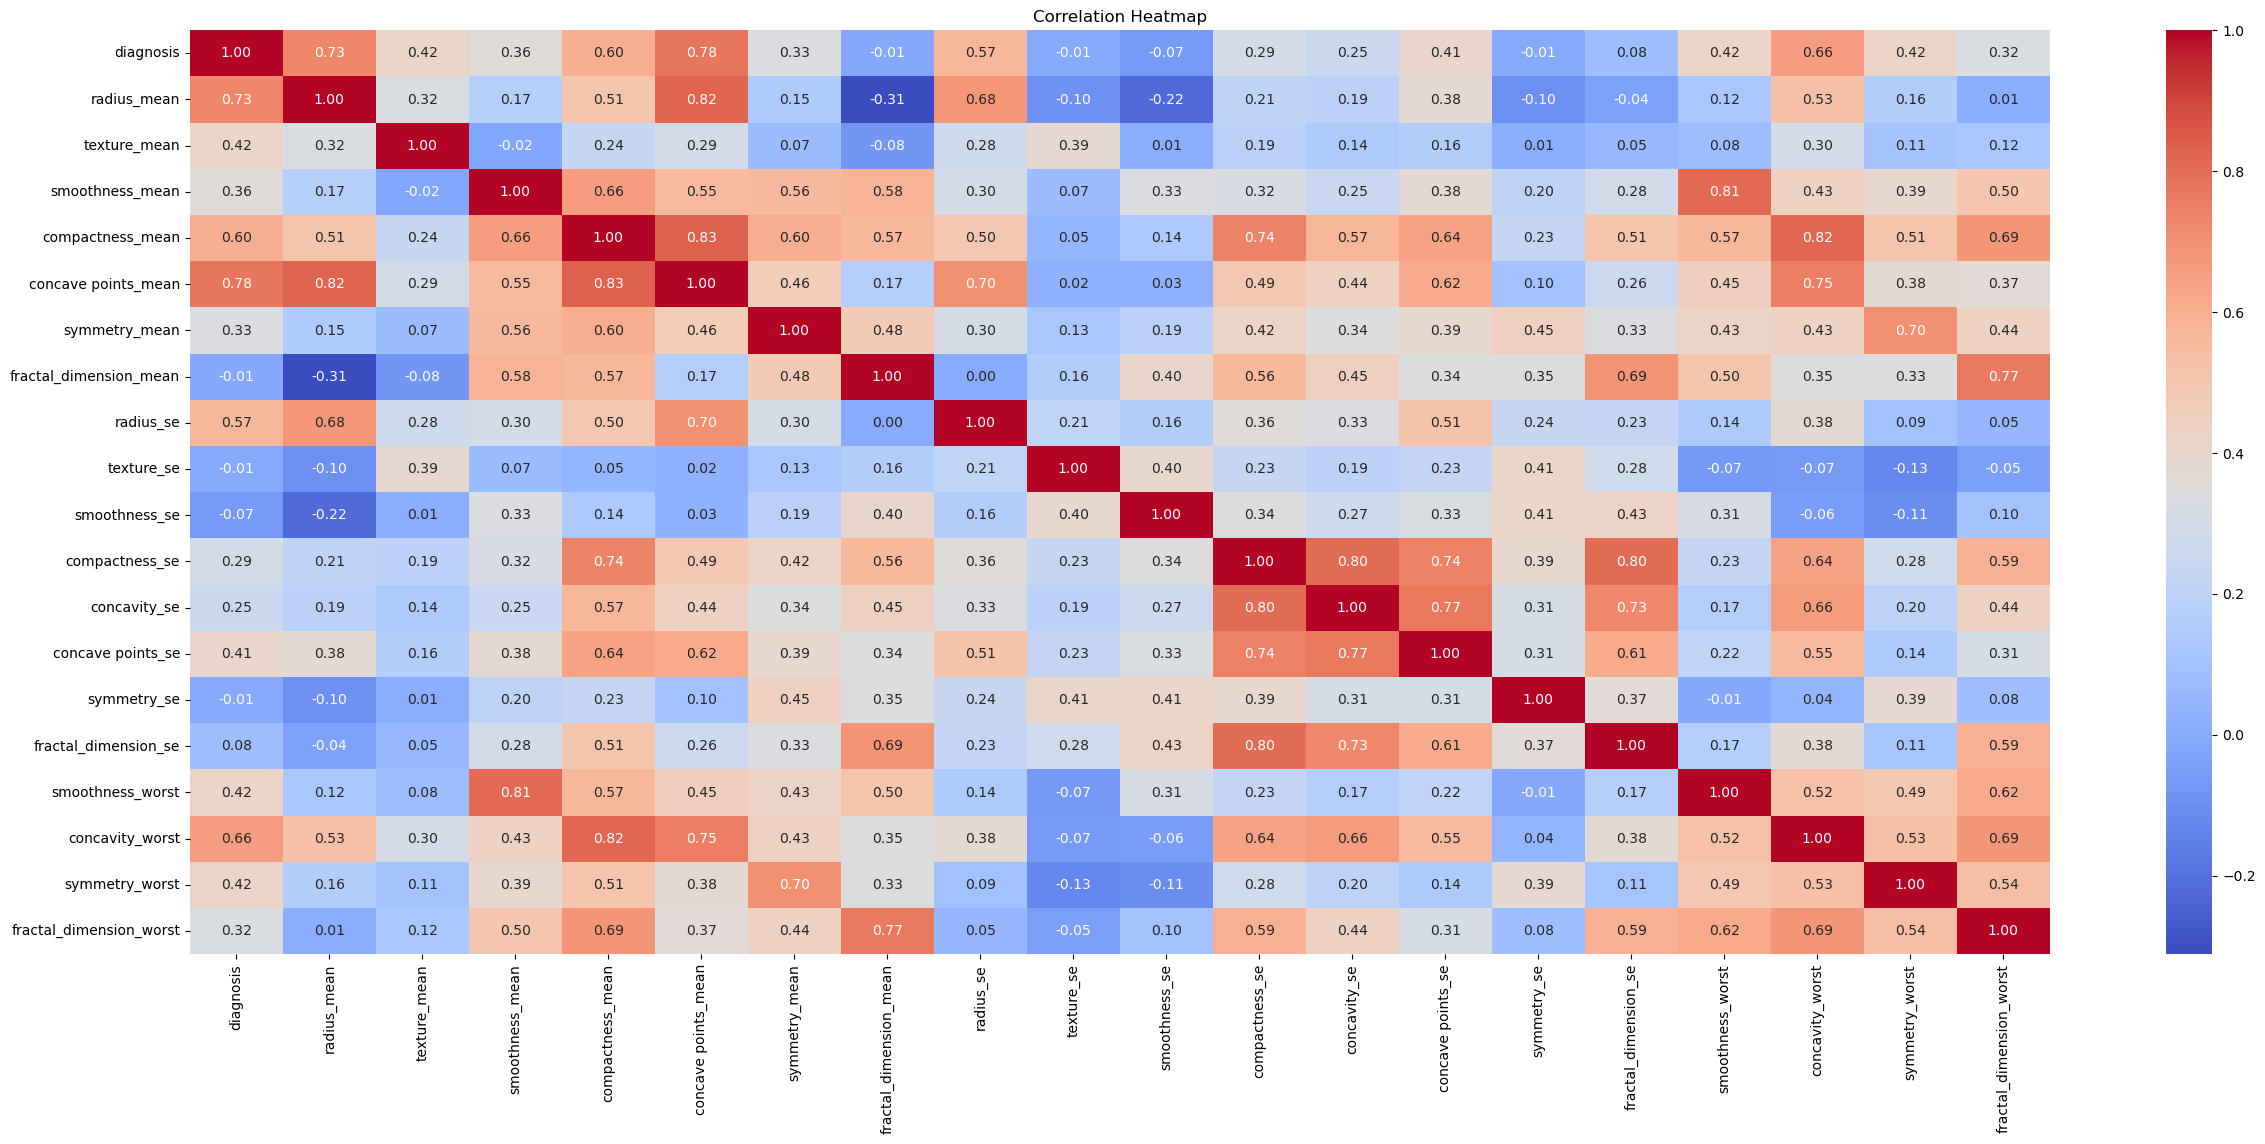

In [4]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(30, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Separate the features and target
# Potential of correlation bias from radius, perimeter, and area feature
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

In [6]:
X

,radius_mean,texture_mean,smoothness_mean,compactness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,0.11840,0.27760,0.14710,0.2419,0.07871,1.0950,0.9053,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,0.16220,0.7119,0.4601,0.11890
1,20.57,17.77,0.08474,0.07864,0.07017,0.1812,0.05667,0.5435,0.7339,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,0.12380,0.2416,0.2750,0.08902
2,19.69,21.25,0.10960,0.15990,0.12790,0.2069,0.05999,0.7456,0.7869,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,0.14440,0.4504,0.3613,0.08758
3,11.42,20.38,0.14250,0.28390,0.10520,0.2597,0.09744,0.4956,1.1560,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,0.20980,0.6869,0.6638,0.17300
4,20.29,14.34,0.10030,0.13280,0.10430,0.1809,0.05883,0.7572,0.7813,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,0.13740,0.4000,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,0.11100,0.11590,0.13890,0.1726,0.05623,1.1760,1.2560,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,0.14100,0.4107,0.2060,0.07115
565,20.13,28.25,0.09780,0.10340,0.09791,0.1752,0.05533,0.7655,2.4630,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,0.11660,0.3215,0.2572,0.06637
566,16.60,28.08,0.08455,0.10230,0.05302,0.1590,0.05648,0.4564,1.0750,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,0.11390,0.3403,0.2218,0.07820
567,20.60,29.33,0.11780,0.27700,0.15200,0.2397,0.07016,0.7260,1.5950,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,0.16500,0.9387,0.4087,0.12400


In [7]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int32

### Fitting the Neural network model on the extracted features against the target variable and fine tuning the hyperparameters that will be used to configure the model.

Epoch: 0 Train MSE: 0.6168606964756965 Valid MSE: 0.38064452656486636
Epoch: 1 Train MSE: 0.35821262401899295 Valid MSE: 0.2707811804454453
Epoch: 2 Train MSE: 0.26154594193070657 Valid MSE: 0.24248080133790786
Epoch: 3 Train MSE: 0.2326412302664831 Valid MSE: 0.2392126002137031
Epoch: 4 Train MSE: 0.22569553621520738 Valid MSE: 0.24038222898797953
Epoch: 5 Train MSE: 0.22420867866783586 Valid MSE: 0.2414445849303971
Epoch: 6 Train MSE: 0.22386964108378016 Valid MSE: 0.24199640518076476
Epoch: 7 Train MSE: 0.2237521864355511 Valid MSE: 0.24223811281830812
Epoch: 8 Train MSE: 0.22367598141057488 Valid MSE: 0.24233072573964615
Epoch: 9 Train MSE: 0.22360736524468083 Valid MSE: 0.24235686076522017
Epoch: 10 Train MSE: 0.22354006675768093 Valid MSE: 0.24235412780529866
Epoch: 11 Train MSE: 0.22347282658009077 Valid MSE: 0.2423389326386336
Epoch: 12 Train MSE: 0.22340562270935954 Valid MSE: 0.24231824806035918
Epoch: 13 Train MSE: 0.22333814170125216 Valid MSE: 0.24229492655472282
Epoch: 14

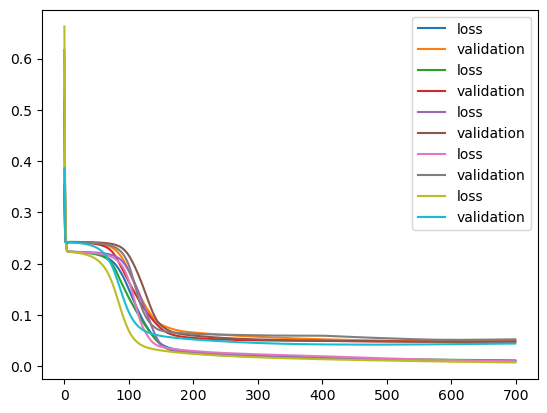

In [13]:
epocs = 700
learn_rate = .001
batch_size = 80
val_split = .2
verbose = 1

strings = []
total_error = 0

for i in range(5):

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_train = y_train.to_numpy().reshape(-1,1)
    y_test = y_test.to_numpy().reshape(-1,1)

    layer_structure = [X_train.shape[1],5,3,2,1]
    nn = Neural(layer_structure, epocs, learn_rate, batch_size, val_split, verbose)

    nn.fit(X_train, y_train)

    y_pred = nn.predict(X_test)

    nn.plot_learning()
    mse = mean_squared_error(y_test, y_pred)
    mse_str = "Test error " + str(i) + ": " + str(mse)
    strings.append(mse_str)
    total_error += mse

mean_test_eror = total_error / 5
for s in strings:
    print(s)
print("Mean test error: ", mean_test_eror)